## Mask R-CNN - Simulate the `Detection Layer` Process for COCO images

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
    
import numpy as np
import mrcnn.utils     as utils
import mrcnn.visualize as visualize

from mrcnn.prep_notebook import build_mrcnn_inference_pipeline, run_mrcnn_inference_pipeline,run_mrcnn_detection
from mrcnn.visualize     import display_training_batch
from mrcnn.prep_notebook import get_inference_batch, get_image_batch, get_training_batch,get_evaluate_batch
from mrcnn.coco          import prep_coco_dataset
from mrcnn.datagen       import data_gen_simulate

input_parms  =" --batch_size     1  "
input_parms +=" --lr 0.00001     --val_steps 8 " 
input_parms +=" --mrcnn_logs_dir train_mrcnn_coco "
input_parms +=" --fcn_logs_dir   train_fcn8_subset " 
input_parms +=" --mrcnn_model    last "
input_parms +=" --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15 "
input_parms +=" --sysout         screen "
# input_parms = " --epochs         2   --steps_in_epoch 32  --last_epoch 0 "
# input_parms +=" --fcn_model      init "
# input_parms +=" --opt            adam "
# input_parms +=" --fcn_arch       fcn8 " 
# input_parms +=" --fcn_layers     all " 
# input_parms +=" --coco_classes   62 63 67 78 79 80 81 82 72 73 74 75 76 77"
# input_parms +=" --new_log_folder    "
parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
print(args)

# mrcnn_model.config.DETECTION_MAX_INSTANCES = 300
# mrcnn_model.config.DETECTION_MIN_CONFIDENCE = 0.1

Current working dir:  E:\git_projs\MRCNN3\notebooks
appending '..' to sys.path


Using TensorFlow backend.


Namespace(batch_size='1', coco_classes=[78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15], epochs=1, fcn_arch='FCN32', fcn_layers='fcn32+', fcn_logs_dir='train_fcn8_subset', fcn_losses='fcn_bce_loss', fcn_model='last', last_epoch=0, lr='0.00001', mrcnn_exclude_layers=None, mrcnn_logs_dir='train_mrcnn_coco', mrcnn_model='last', new_log_folder=False, opt='ADAGRAD', scale_factor=4, steps_in_epoch=1, sysout='SCREEN', val_steps='8')


In [3]:
mrcnn_model = build_mrcnn_inference_pipeline(args = args, verbose = 0)


--> Execution started at: 12-06-2018 @ 13:55:31
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 

Arguments passed :
--------------------
batch_size                     1
coco_classes                   [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
epochs                         1
fcn_arch                       FCN32
fcn_layers                     fcn32+
fcn_logs_dir                   train_fcn8_subset
fcn_losses                     fcn_bce_loss
fcn_model                      last
last_epoch                     0
lr                             0.00001
mrcnn_exclude_layers           None
mrcnn_logs_dir                 train_mrcnn_coco
mrcnn_model                    last
new_log_folder                 False
opt                            ADAGRAD
scale_factor                   4
steps_in_epoch                 1
sysout                         SCREEN
val_steps                      8


>>> Initialize Paths
 windows  Windows

In [4]:
# mrcnn_model.config.display()
mrcnn_model.display_layer_info()

 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class_lambda/mrcnn_class:0           Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox_lambda/mrcnn_bbox:0             Type: float32           Shape: (?, 1000, 81, 4)
 layer:  4    output name: cntxt_layer/pred_heatmap:0                 Type: float32           Shape: (1, 256, 256, 81)
 layer:  5    output name: cntxt_layer/pred_heatmap_scores:0          Type: float32           Shape: (1, 81, 200, 23)


## Load Training dataset

In [155]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
## train  : 82081 |  train + val35k : 117266
## val    : 40137 | val35k : 35185 |  minival:  4952
## 
#   'accessory':   [27, 28, 31, 32, 33],          #   'animal':     [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#   'appliance':  [78, 79, 80, 81, 82],           #   'background': [0],
#   'electronic': [72, 73, 74, 75, 76, 77],       #   'food':       [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
#   'furniture':  [62, 63, 64, 65, 67, 70],       #   'indoor':     [84, 85, 86, 87, 88, 89, 90],
#   'kitchen':    [44, 46, 47, 48, 49, 50, 51],   #   'outdoor':    [10, 11, 13, 14, 15],
#   'person':     [1],                            #   'sports':     [34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
#   'vehicle':    [2, 3, 4, 5, 6, 7, 8, 9]} 
## " --coco_classes:
##    appliance : 78 79 80 81 82                  kitchen: 44 46 47 48 49 50 51 
##    sports    : 34 35 36 37 38 39 40 41 42 43   indoor : 10 11 13 14 15
# ------------------------------------------------------------------------------------
# load_class_ids = [62,63,64,65,67,70,   44,46,47,48,49,50,51,  72,73,74,75,76,77 , 82,61]
# load_class_ids = [62,63,67, 78,79,80,81,82,  72,73,74,75,76,77]
load_class_ids = args.coco_classes
dataset_train, train_generator = prep_coco_dataset(["train", 'val35k'], mrcnn_model.config, generator = True, shuffle = False, return_coco =True, load_coco_classes=load_class_ids)
 

COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=28.10s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  40400
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
 image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=15.38s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatas

In [8]:
# pp.pprint(dataset_train.category_to_class_map)
# print()
# pp.pprint(dataset_train.category_to_external_class_map)
# print(' dataset_train.source_objs:   ',dataset_train.source_objs)
# print(dataset_train.image_info[0].keys())
# for i in range(10):
#     p = dataset_train.image_info[i]
#     print(i,p['id'], p['source'], p['path'])
# print("Testing Dataset Image Count: {}".format(len(dataset_train.image_ids)))
# print("Testing Dataset Class Count: {}".format(dataset_train.num_classes))
# pp.pprint(dataset_train.ext_to_int_id)
# pp.pprint(dataset_train.int_to_ext_id)
# for i, info in enumerate(dataset_test.class_info):
#     print("{:3}. {:50}".format(i, info['name']))
# pp.pprint(dataset_train.active_coco_class_ids)
# pp.pprint(dataset_train.active_class_ids) 
print(dataset_train.display_class_info())

 Class Information 
-------------------
BG                         source:              ext_id:   0   internal_id:   0  category: background            img_count:      0
person                     source: coco         ext_id:   1   internal_id:   1  category: person                img_count:  64115
bicycle                    source: coco         ext_id:   2   internal_id:   2  category: vehicle               img_count:   3252
car                        source: coco         ext_id:   3   internal_id:   3  category: vehicle               img_count:  12251
motorcycle                 source: coco         ext_id:   4   internal_id:   4  category: vehicle               img_count:   3502
airplane                   source: coco         ext_id:   5   internal_id:   5  category: vehicle               img_count:   2986
bus                        source: coco         ext_id:   6   internal_id:   6  category: vehicle               img_count:   3952
train                      source: coco         ex

## Display Images

### Load using next(generator)

 Image_id    :  2  Reference:  http://cocodataset.org/#explore?id=9 Coco Id: 9
 Image meta [   2  480  640    3  128    0  896 1024    1    1]
 Class ids   :  (8,)    [46 46 51 46 50 50 50 50]
 Class Names :  ['bowl', 'bowl', 'broccoli', 'bowl', 'orange', 'orange', 'orange', 'orange']


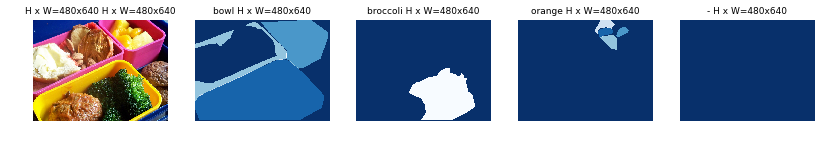

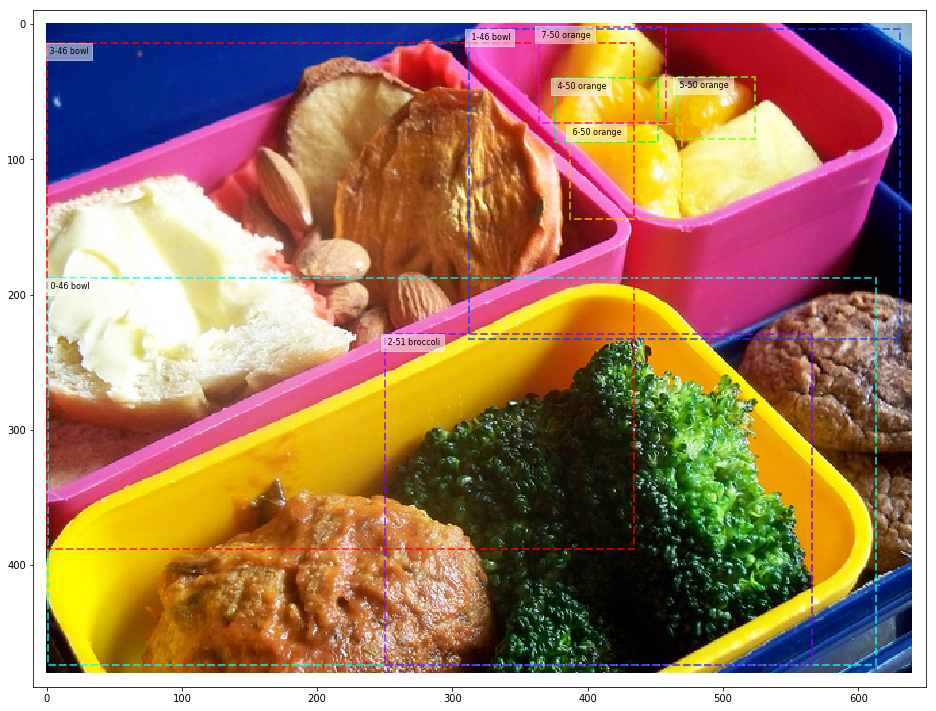

In [11]:
train_batch_x, _ = next(train_generator)
display_training_batch(dataset_train, train_batch_x)
# dataset_train.display_annotation_info(0)

### Load a specific image using image_id -Display image with Ground Truth bounding boxes and masks

 batch size is : 1
 load image ud:  2
 Image_id    :  2  Reference:  http://cocodataset.org/#explore?id=9 Coco Id: 9
 Image meta [   2  480  640    3  128    0  896 1024    1    1]
 Class ids   :  (8,)    [46 46 51 46 50 50 50 50]
 Class Names :  ['bowl', 'bowl', 'broccoli', 'bowl', 'orange', 'orange', 'orange', 'orange']


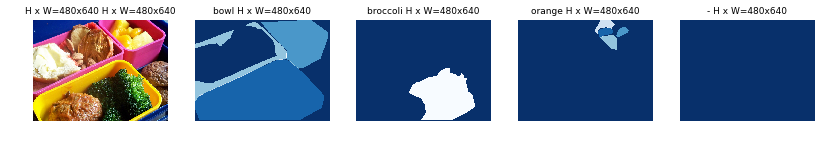

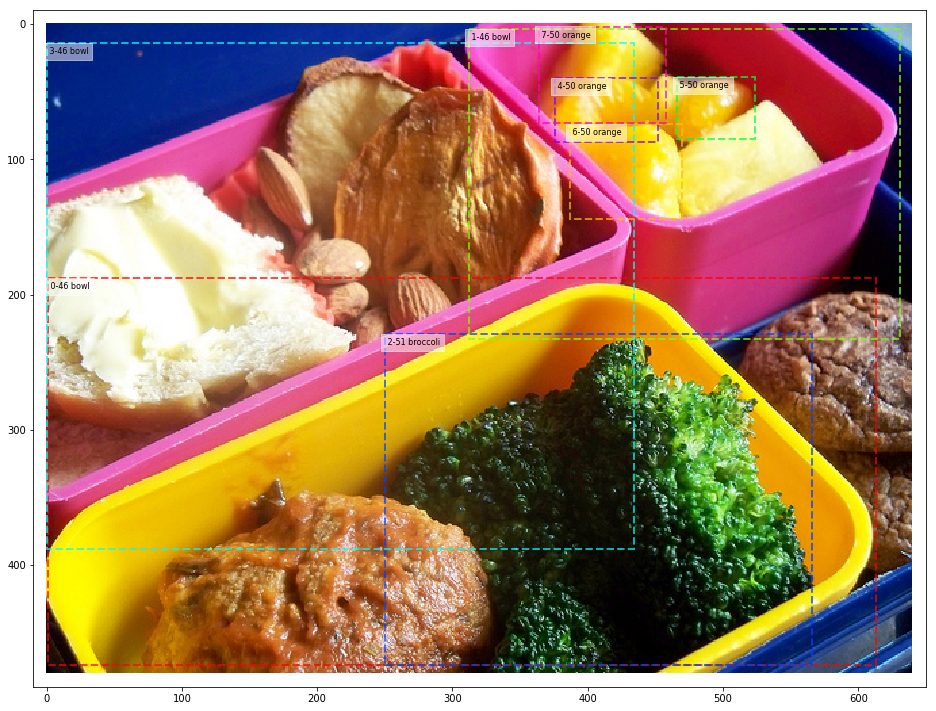

In [144]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 89243: Person, bicylce and traiffic lights
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
## 26763 Table, chair, cup , bowl, bottle
## 49316 Table, book, backpack, many bottles
## 12902 Car , truck and traffic light tree
## 57327 person and horses
## 26026 -- mountain, skiers, skiboards 
##  7719 -- people, bottles, handbags
## 27711 -- persons and boats
## 18045 -- person     
## 36769 -- people in meeting room with a 'giraffe'detection?
##  8634 -- person
## 30531 -- tennis players 
##  8645 -- two people
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
# IMAGE_LIST = [33477]
# IMAGE_LIST = [29731]
# IMAGE_LIST = [26763]
# IMAGE_LIST = [89243]  ## 89243: Person, bicylce and traiffic lights
# IMAGE_LIST = [43168]   ## 43168 Multiple umbrella, chairs, beds
# IMAGE_LIST = [43168]   ## 43168 Multiple umbrella, chairs, beds
IMAGE_LIST= [30531]
IMAGE_LIST = [2]
# IMAGE_LIST = [30533]

# train_batch_x = get_training_batch(dataset_train, mrcnn_model.config, IMAGE_LIST)
# train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_LIST)
# visualize.display_training_batch(dataset_train, train_batch_x)
# dataset_train.display_annotation_info(IMAGE_LIST)
 

#### `get_evaluate_batch()`

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 Image_id    :  6  Reference:  http://cocodataset.org/#explore?id=393241 Coco Id: 393241
 Image meta [   6  426  640    3  171    0  853 1024    1    1]
 Class ids   :  (18,)    [30  1  1  1  1  1  1  1  1  1  3  3  1  3  3  1  1  1]
 Class Names :  ['frisbee', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'person', 'car', 'car', 'person', 'person', 'person']


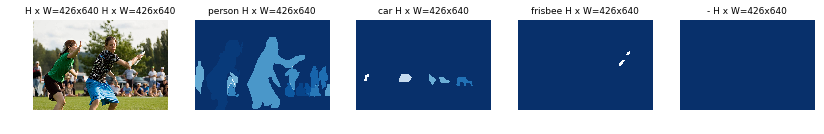

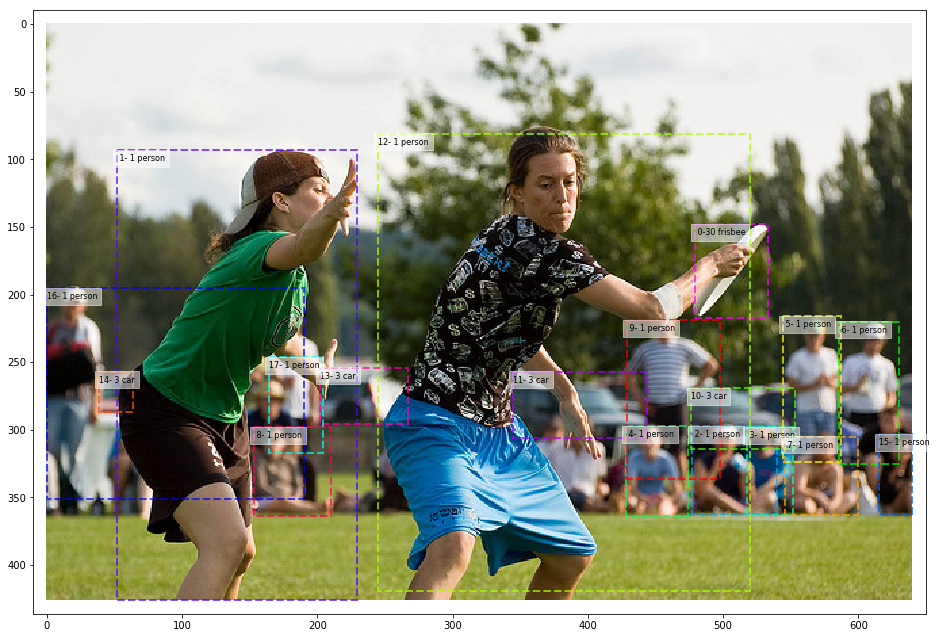

(1, 1024, 1024, 3)
(1, 89)
(1, 100)
(1, 100, 4)


In [166]:
# print(train_batch_x[0].shape)
# visualize.display_image(utils.unmold_image(batch_x[0][0], mrcnn_model.config))
# from mrcnn.prep_notebook import 
batch_x = get_evaluate_batch(dataset_train, mrcnn_model.config, generator = train_generator)
type(batch_x)
for i in batch_x:
    print(i.shape)
# visualize.display_image(utils.unmold_image(batch_x[0][0], mrcnn_model.config))

In [169]:
print(batch_x[3][0,:20])

[[ 408  767  518  853]
 [ 320   83  853  366]
 [ 647  763  751  864]
 [ 648  829  752  883]
 [ 647  685  754  759]
 [ 517  871  690  939]
 [ 523  938  691 1008]
 [ 659  874  752  960]
 [ 648  245  754  336]
 [ 522  687  709  797]
 [ 602  762  674  885]
 [ 583  552  661  711]
 [ 300  392  842  832]
 [ 578  323  645  427]
 [ 583   62  631  102]
 [ 656  984  751 1024]
 [ 483    0  733  304]
 [ 565  262  679  326]
 [   0    0    0    0]
 [   0    0    0    0]]


### Display random samples from dataset

#### Display top masks for sample images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 7)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

####  Dispaly a random image from dataset_test

In [ ]:
# Load random image and mask. ### 27711 persons and boats
image_id = np.random.choice(dataset_test.image_ids)
image    = dataset_test.load_image(image_id)
mask, class_ids = dataset_test.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_test.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)
visualize.display_instances(image, bbox, class_ids, dataset_test.class_names)

### Get next image from generator and display 

In [ ]:
bbox_ixs = np.arange(20,26)
print(bbox_ixs)
# print(r['scores'][bbox_ixs])
visualize.display_instances(image, r['rois'][bbox_ixs], r['class_ids'][bbox_ixs], 
                            dataset_test.class_names, r['scores'][bbox_ixs], ax=visualize.get_ax(size=12))

###  Print some model information 

In [ ]:
mrcnn_model.layer_info()

## Push Data thru model using get_layer_output()

In [12]:
results= run_mrcnn_inference_pipeline(mrcnn_model, dataset_train, train_batch_x, verbose = True)

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)

Requested layers:
-----------------
Layer   0:  (mrcnn_detection/PyFunc:0                ) 	  Input shape: <unknown>
Layer   1:  (ROI/rpn_roi_proposals:0                 ) 	  Input shape: (1, ?, ?)
Layer   2:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Input shape: (?, 1000, 81)
Layer   3:  (mrcnn_bbox_lambda/mrcnn_bbox:0          ) 	  Input shape: (?, 1000, 81, 4)
Layer   4:  (cntxt_layer/pred_heatmap:0              ) 	  Input shape: (1, 256, 256, 81)
Layer   5:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Input shape: (1, 81, 200, 23)
    Wrapper for Detection Layer : call()  <class 'list'> 4
      rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
      mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
      mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'nu

#### Load output from pipeline into variables

In [19]:
print(len(results['mrcnn_output']))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
model_mrcnn_detection    = results['mrcnn_output'][0]          # layer:  0   shape: (1, 100, 6)
model_rpn_roi_proposals  = results['mrcnn_output'][1]          # layer:  1   shape: (1, 1000, 4)
model_mrcnn_class        = results['mrcnn_output'][2]          # layer:  2   shape: (1, 1000, 81)
model_mrcnn_bbox         = results['mrcnn_output'][3]          # layer:  3   shape: (1, 1000, 81, 4)
model_pr_hm              = results['mrcnn_output'][4]          # layer:  4   shape: (1, 256, 256, 81)
model_pr_hm_scores       = results['mrcnn_output'][5]          # layer:  5   shape: (1, 81, 100, 11)
# print(type(model_output[4]))
# print(type(output_rois))
for i in results['mrcnn_output']:
    print( i.shape)

6
(1, 200, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 256, 256, 81)
(1, 81, 200, 23)


#### Load input to pipeline in vars

In [20]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image      =  results['mrcnn_input'][0]
input_image_meta =  results['mrcnn_input'][1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
# input_gt_class_ids   =  train_batch_x[4]
# input_gt_bboxes      =  train_batch_x[5]

print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
# print(' input_gt_class_ids      :', input_gt_class_ids.shape)
# print(' input_gt_bboxes         :', input_gt_bboxes.shape)
print(input_image.shape)

h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('height/width', h,w)

 Input image shape is    : (1, 1024, 1024, 3)
 Input image_meta        : <class 'numpy.ndarray'> (1, 89)
 input_image_meta        : [   2  480  640    3  128    0  896 1024    1    1]
(1, 1024, 1024, 3)
height/width 1024 1024


#### Display output shapes from `run_pipeline~`

In [18]:
print(results.keys())
for i in results.keys():
    print(i, type(results[i]))
print('image_batch')
print(results['image_batch'].shape)
print('mrcnn_output')
for i in results['mrcnn_input']:
    print(i.shape)
print('mrcnn_output')
for i in results['mrcnn_output']:
    print(i.shape)    

dict_keys(['mrcnn_output', 'image_batch', 'mrcnn_input'])
mrcnn_output <class 'list'>
image_batch <class 'numpy.ndarray'>
mrcnn_input <class 'list'>
image_batch
(1, 1024, 1024, 3)
mrcnn_output
(1, 1024, 1024, 3)
(1, 89)
(1, 261888, 1)
(1, 256, 4)
(1, 100)
(1, 100, 4)
mrcnn_output
(1, 200, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 256, 256, 81)
(1, 81, 200, 23)


#### display outputs

In [ ]:
print(model_mrcnn_detection.shape)
print(model_mrcnn_detection[0,:10])
# print('mrcnn_class shape:', mrcnn_class.shape)
# print('mrcnn_bbox shape :', mrcnn_bbox.shape)
# pred_scores  = np.max(mrcnn_class,axis = -1)
# pred_classes = np.argmax(mrcnn_class,axis = -1)
# # pred_classes_2 = np.take(out_mrcnn_bbox, pred_classes, axis = 2)  
# print(pred_classes.shape)
# print(pred_classes[0])

# print(' pred_scores \n',pred_scores)
# print(' pred_classes \n', pred_classes)
# for cls,score in zip(pred_classes,pred_scores):
#     print(' {:3d} {:.<20s} {:4f} '.format(cls, class_names[cls],score))


# print(input_gt_boxes.shape, input_image.shape)
# print('output_rois',model_rpn_roi_proposals.shape, 'deltas ', model_mrcnn_bbox.shape, 'class_ids ', model_mrcnn_class.shape)
# print(model_rpn_roi_proposals[0,:20])
# print(model_rpn_roi_proposals[0,:20]*[h,w,h,w])
# print(input_gt_class_ids)
# print(input_normlzd_gt_bboxes)
# print(input_gt_bboxes_norm.shape)
# print(rpn_roi_proposals.shape)

## `Detection_Layer`

### `clip_to_window( )`

In [ ]:
def clip_to_window(window, boxes):
    '''
    window: (y1, x1, y2, x2). The window in the image we want to clip to.
    boxes: [N, (y1, x1, y2, x2)]
    '''
    print(boxes.shape)
    boxes[:, 0] = np.maximum(np.minimum(boxes[:, 0], window[2]), window[0])
    boxes[:, 1] = np.maximum(np.minimum(boxes[:, 1], window[3]), window[1])
    boxes[:, 2] = np.maximum(np.minimum(boxes[:, 2], window[2]), window[0])
    boxes[:, 3] = np.maximum(np.minimum(boxes[:, 3], window[3]), window[1])
    return boxes

### `refine_detections` all in one 

####  Setup tensors to be passed to `detections_target_graph()`
    detections = DetectionLayer(config, name="mrcnn_detection") ([rpn_proposal_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

In [ ]:
# with  sess.as_default():
inputs = [model_rpn_roi_proposals, model_mrcnn_class, model_mrcnn_bbox, input_image_meta]
print(model_rpn_roi_proposals.dtype, model_mrcnn_class.dtype, model_mrcnn_bbox.dtype)
print(type(model_rpn_roi_proposals), model_rpn_roi_proposals.shape)
print(type(model_mrcnn_class), model_mrcnn_class.shape)
print(type(model_mrcnn_bbox) , model_mrcnn_bbox.shape)

# print('    Detection Layer : call() ', type(inputs), len(inputs))    
# print('     rpn_proposals_roi  :',  inputs[0].shape )
# print('     mrcnn_class.shape  :',  inputs[1].shape ) 
# print('     mrcnn_bboxes.shape :',  inputs[2].shape )
# print('     input_image_meta   :',  inputs[3].shape )     


#### `refine_detections()`

In [ ]:

def refine_detections(rois, probs, deltas, window, config):
    '''
    Refine classified proposals and filter overlaps and return final detections.

    Inputs:
    ------
        
    rois:           rpn_rois    - [N, (y1, x1, y2, x2)] in normalized coordinates
    
                    passed from PROPOSAL_LAYER
                                  
    probs:          mrcnn_class - [N, num_classes]. Class probabilities.
    deltas:         mrcnn_bbox  - [N, num_classes, (dy, dx, log(dh), log(dw))]. 
                                  Class-specific bounding box deltas.
                    
                    passed from FPN_CLASSIFIER_GRAPH              
    window:         
    (y1, x1, y2, x2) in image coordinates. The part of the image
                    that contains the image excluding the padding.

    Returns:
    --------
    detections      [M, (y1, x1, y2, x2, class_id, score)]
                    M - determined by DETECTION_MAX_INSTANCES
                    
                    detection bounding boxes -- these have had the corresponding 
                    deltas applied, and their boundries clipped to the image window
    '''

    
    ##----------------------------------------------------------------------------
    ##  1. Find Class IDs with higest scores for each per ROI
    ##----------------------------------------------------------------------------
    class_ids       = np.argmax(probs, axis=1)
    
    ##----------------------------------------------------------------------------
    ##  2. Get Class probability(score) and bbox delta of the top class of each ROI
    ##----------------------------------------------------------------------------
    class_scores    =  probs[np.arange(class_ids.shape[0]), class_ids]
    deltas_specific = deltas[np.arange(deltas.shape[0])   , class_ids]
    
    ##----------------------------------------------------------------------------
    ##  3. Apply bounding box delta to the corrsponding rpn_proposal
    ##----------------------------------------------------------------------------
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois    = apply_box_deltas_np(rois, deltas_specific * config.BBOX_STD_DEV)
    
    ##----------------------------------------------------------------------------
    ##  4. Convert the refined roi coordiates from normalized to NN image domain
    ##  5.  Clip boxes to image window
    ##  6.  Round and cast to int since we're deadling with pixels now
    ##----------------------------------------------------------------------------
    # TODO: better to keep them normalized until later   
    height, width   = config.IMAGE_SHAPE[:2]
    refined_rois   *= np.array([height, width, height, width])
    
    refined_rois    = clip_to_window(window, refined_rois)
    refined_rois    = np.rint(refined_rois).astype(np.int32)

    ##----------------------------------------------------------------------------
    ##  7.  TODO: Filter out boxes with zero area
    ##----------------------------------------------------------------------------

    ##----------------------------------------------------------------------------
    ##  8.  Filter out background boxes
    ##      keep : contains indices of non-zero elements in class_ids
    ##      config.DETECTION_MIN_CONFIDENCE == 0 
    ##      np.intersect: find indices into class_ids that satisfy:
    ##        -  class_id     >  0 
    ##        -  class_scores >=            config.DETECTION_MIN_CONFIDENCE (0.3)
    ##----------------------------------------------------------------------------
    keep = np.where(class_ids > 0)[0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        keep = np.intersect1d(keep, np.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[0])

    ##----------------------------------------------------------------------------
    ##  9.  Apply per-class NMS
    ##----------------------------------------------------------------------------
    pre_nms_class_ids = class_ids[keep]
    pre_nms_scores    = class_scores[keep]
    pre_nms_rois      = refined_rois[keep]
    nms_keep          = []
    # print(' apply per class nms')    
    for class_id in np.unique(pre_nms_class_ids):
        # Pick detections of this class
        ixs = np.where(pre_nms_class_ids == class_id)[0]

        # print('class_id : ', class_id)
        # print('pre_nms_rois.shape:', pre_nms_rois[ixs].shape)
        # pp.pprint(pre_nms_rois[ixs])
        # print('pre_nms_scores.shape :', pre_nms_scores[ixs].shape)
        # pp.pprint(pre_nms_scores[ixs])    
        # Apply NMS
        class_keep = non_max_suppression(pre_nms_rois[ixs], 
                                         pre_nms_scores[ixs],
                                         config.DETECTION_NMS_THRESHOLD)
        # Map indicies
        class_keep = keep[ixs[class_keep]]
        nms_keep   = np.union1d(nms_keep, class_keep)
    
    keep = np.intersect1d(keep, nms_keep).astype(np.int32)

    ##----------------------------------------------------------------------------
    ## 10.  Keep top detections
    ##----------------------------------------------------------------------------
    roi_count = config.DETECTION_MAX_INSTANCES
    top_ids   = np.argsort(class_scores[keep])[::-1][:roi_count]
    keep      = keep[top_ids]

    ##----------------------------------------------------------------------------
    ## 11.  Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    ##      Coordinates are in image domain.
    ##----------------------------------------------------------------------------
    result = np.hstack((refined_rois[keep],
                        class_ids   [keep][..., np.newaxis],
                        class_scores[keep][..., np.newaxis]))

    return result


##  `Detection_Layer` step by step

###  prep input calling `refine detections() `

In [21]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)


In [28]:
from mrcnn.detect_layer import clip_to_window
img_idx = 0 
i1, i2, window, _ =  utils.parse_image_meta(input_image_meta)
rois   = model_rpn_roi_proposals[img_idx]
probs  = model_mrcnn_class[img_idx]
deltas = model_mrcnn_bbox[img_idx] 
window = window[img_idx]
config = mrcnn_model.config
print(i1, i2,window)
class_names = dataset_train.class_names 
active_classes = dataset_train.active_class_ids
active_classes = sorted(dataset_train.active_class_info.keys())
print(active_classes)

[2] [[480 640   3]] [ 128    0  896 1024]
[10, 11, 12, 13, 14, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 69, 70, 71, 72, 73]


### `refine_detections` step by step

####  Simulate loop calling `refine detections() `

In [29]:
# def refine_detections(rois, probs, deltas, window, config):

##----------------------------------------------------------------------------
##  for each ROI
##  1. Find Class IDs, Score, and bbox Delta corresponding to the class with 
##     the highest score 
##----------------------------------------------------------------------------
class_ids       = np.argmax(probs, axis=1)
print(' probs shape: {}   deltas.shape {}  rois.shape{} '.format(probs.shape,deltas.shape, rois.shape))
class_scores    =  probs[np.arange(class_ids.shape[0]), class_ids]
deltas_specific = deltas[np.arange(deltas.shape[0])   , class_ids]

#display
print(' class_ids argmax(probs) shape', class_ids.shape, '  class_scores.shape: ',class_scores.shape)
print(' min_scores:', min(class_scores), '  max:', max(class_scores))
print(class_ids[:40])
detections = [str(scr) + '  '+ str(cls)+' - '+ class_names[cls] for scr, cls in zip(class_scores, class_ids)]
 
for i in range(10) :
    print(detections[i])

# display some of the argmax classes bboxes
print(' deltas_specific ', deltas_specific.shape)
# print(deltas_specific[:5])
# print(deltas[:5, indexes])

 probs shape: (1000, 81)   deltas.shape (1000, 81, 4)  rois.shape(1000, 4) 
 class_ids argmax(probs) shape (1000,)   class_scores.shape:  (1000,)
 min_scores: 0.18810628   max: 1.0
[51 49 49  0 50 51 50 49 47 46 49 46 50 51 49 46 50 46 50 46  0 49  0 49  0  0  0  0  0 46  0  0 50
 46 50 46 50 51 49  0]
0.9582778  51 - broccoli
0.6636298  49 - sandwich
0.5902875  49 - sandwich
0.30276152  0 - BG
0.99199647  50 - orange
0.89825314  51 - broccoli
0.78571856  50 - orange
0.6220384  49 - sandwich
0.20853895  47 - banana
0.9815512  46 - bowl
 deltas_specific  (1000, 4)


####  Apply bbox adjustments to rois to get `refined_rois`

In [30]:
##----------------------------------------------------------------------------
##  3. Apply bounding box delta to the corrsponding rpn_proposal
##----------------------------------------------------------------------------
# Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
refined_rois    = utils.apply_box_deltas_np(rois, deltas_specific * config.BBOX_STD_DEV)

print('rois ', rois.shape,'    refined_rois shape: ',refined_rois.shape)
# print('\nrois - unadjusted ')
# print(rois[:5])
# print('\nadjustments ')
# print(deltas_specific[:5])
# print('\nrois - adjusted ')
# print(refined_rois[:10])

##----------------------------------------------------------------------------
##  4. Convert the refined roi coordiates from normalized to image domain
##----------------------------------------------------------------------------
# TODO: better to keep them normalized until later   
height, width   = config.IMAGE_SHAPE[:2]
refined_rois   *= np.array([height, width, height, width])

print(window)
print('\nrois - adjusted / image_domain')
print(refined_rois[:20])


# print(window)
# test_box = np.array([[10,10,40,40]])
# print(test_bovx.shape)
# print(clip_to_window(window,test_box))

##----------------------------------------------------------------------------
##  5.  Clip boxes to image window
##  6.  Round and cast to int since we're deadling with pixels now
##----------------------------------------------------------------------------
refined_rois    = clip_to_window(window, refined_rois)
refined_rois    = np.rint(refined_rois).astype(np.int32)
print(refined_rois[:20])

rois  (1000, 4)     refined_rois shape:  (1000, 4)
[ 128    0  896 1024]

rois - adjusted / image_domain
[[ 538.007  441.460  869.924  898.737]
 [ 303.356    1.071  632.471  356.092]
 [ 194.809  310.893  495.372  625.460]
 [ 233.665    4.141  695.983  433.133]
 [ 124.575  574.503  246.045  728.134]
 [ 528.361  436.418  887.382  909.669]
 [ 218.232  741.724  353.361  913.595]
 [ 447.525  827.879  691.246 1018.036]
 [ 667.676   93.051  882.119  553.106]
 [ 133.757  570.353  530.006  991.717]
 [ 454.058  819.448  667.235 1015.151]
 [ 144.222  141.298  571.186  678.982]
 [ 234.081  634.546  355.152  756.534]
 [ 497.189  329.889  879.593  942.266]
 [ 172.272  299.958  493.490  630.241]
 [ 542.984   34.120  909.404  642.849]
 [ 127.015  586.435  261.957  728.328]
 [ 449.305   28.945  910.783  799.858]
 [ 123.224  574.821  240.237  727.745]
 [ 425.846   -2.188  902.441  942.866]]
[[ 538  441  870  899]
 [ 303    1  632  356]
 [ 195  311  495  625]
 [ 234    4  696  433]
 [ 128  575  246  728]

####  display rois

 Max score in bboxIds:  0.99999785  Min Score:  0.29394603
    rois.shape[0]:   1000  limit =  10
 num of bbox_ids :  200
    limit to display :  10
    limit to display :  10
Positive ROIs:  177
Negative ROIs:  823
Positive Ratio: 0.18


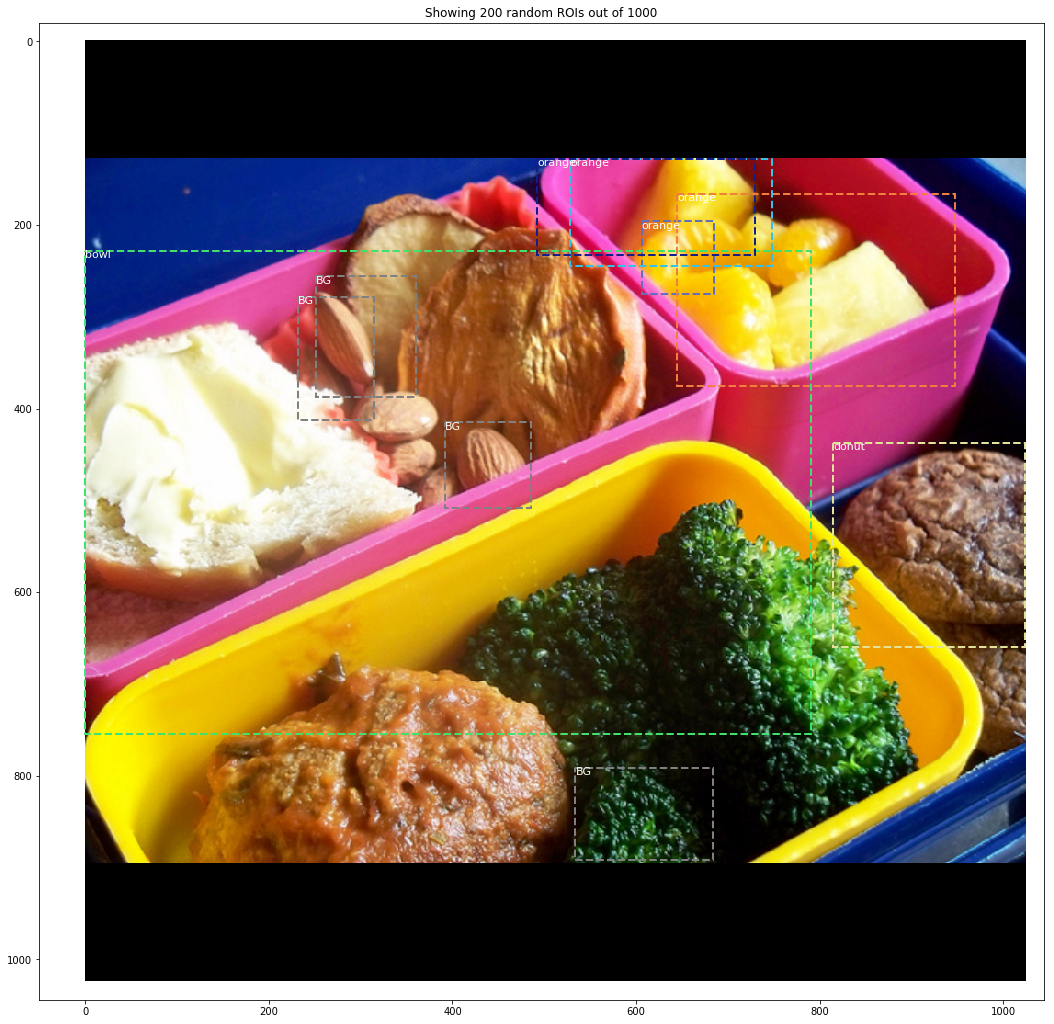

In [38]:
image = utils.unmold_image(input_image[0], mrcnn_model.config)
#print(input_image.shape)
p1 = rois * [1024,1024,1024,1024]
 
# visualize.draw_rois_with_refinements(image, p1, refined_rois,class_ids, class_names,limit = 10, random = False )
# visualize.draw_rois_with_refinements(image, p1, refined_rois,class_ids, class_names,ids=[6,7,8,9]) 
# bbox_ids = list(range(0,500))
print(' Max score in bboxIds: ',np.max(class_scores[bbox_ids]), ' Min Score: ', np.min(class_scores[bbox_ids]))
# visualize.draw_rois(image, p1, class_ids, class_names, bbox_ids = bbox_ids, limit=20)
visualize.draw_rois(image, refined_rois, class_ids, class_names,  limit=10, bbox_ids = list(range(100,300)), display_bg= True)
 

####  Filter out low confidence detections

In [39]:
##----------------------------------------------------------------------------
##  8.  Filter out boxes with class == background and low confidence score 
##      (boxes with class_scores < DETECTION_MIN_CONFIDENCE)
##      keep : contains indices of non-zero elements in class_ids
##      config.DETECTION_MIN_CONFIDENCE == 0.3
##----------------------------------------------------------------------------
keep = np.where(class_ids > 0)[0]
keep_class_zero = np.where(class_ids == 0)[0]
print('keep_class_non   : ', keep.shape )
print('keep_class_zero  : ', keep_class_zero.shape)

# Filter out low confidence boxes
print(config.DETECTION_MIN_CONFIDENCE)
if config.DETECTION_MIN_CONFIDENCE:
    keep_high_confidence = np.intersect1d(keep, np.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
    keep_low_confidence  = np.intersect1d(keep, np.where(class_scores < config.DETECTION_MIN_CONFIDENCE)[0])

pre_nms_class_ids = class_ids[keep_high_confidence]
pre_nms_scores    = class_scores[keep_high_confidence]
pre_nms_rois      = refined_rois[keep_high_confidence]
# print(class_ids)
print('keep               : ', keep.shape)
print('keep_confidence    : ', keep_high_confidence.shape )
print('keep_low_oncifdence: ', keep_low_confidence.shape)

low_conf_class_ids = class_ids[keep_low_confidence]
low_conf_scores    = class_scores[keep_low_confidence]
low_conf_rois      = refined_rois[keep_low_confidence]

print(pre_nms_class_ids.shape, pre_nms_rois.shape, pre_nms_scores.shape)
print(low_conf_class_ids.shape, low_conf_rois.shape, low_conf_scores.shape)
# print(low_conf_scores)

keep_class_non   :  (177,)
keep_class_zero  :  (823,)
0.1
keep               :  (177,)
keep_confidence    :  (177,)
keep_low_oncifdence:  (0,)
(177,) (177, 4) (177,)
(0,) (0, 4) (0,)


#### For those objects with best pred on BG, what is the next highest prediction??

In [63]:
max_0       = np.argmax(probs[keep_class_zero], axis=1)   ## find the max score for the class BGs
print(' max_0:',max_0.shape, max_0[:10])
print(' keep_class_zero[:10]         : ', keep_class_zero.shape, keep_class_zero[:10])
print(' probs[keep_class_zero,max_0] : ', probs[keep_class_zero,max_0][:10])
print(' class_scores[keep_class_zero]: ', class_scores[keep_class_zero][:10])
# print(max_0)
max_1       = np.argmax(probs[keep_class_zero, 1:], axis=1)
print(' max_1: ', max_1.shape, max_1[:10])
max_1 +=1

print(probs[keep_class_zero].shape, max_1.shape)
print(' probs[keep_class_zero,max_1] : ', probs[keep_class_zero,max_1][:10])
# print(max_1)
# for prob, pred_1, pred_2 in zip(probs[keep_class_zero], max_0, max_1):
#     print(pred_1, '    ', prob[pred_1], '  Next: ', pred_2 ,'     ',class_names[pred_2], '   ',prob[pred_2])

 max_0: (823,) [0 0 0 0 0 0 0 0 0 0]
 keep_class_zero[:10]         :  (823,) [ 3 20 22 24 25 26 27 28 30 31]
 probs[keep_class_zero,max_0] :  [0.3028 0.9272 0.6061 0.8669 0.5172 0.4580 0.2507 0.6642 0.4041 0.6784]
 class_scores[keep_class_zero]:  [0.3028 0.9272 0.6061 0.8669 0.5172 0.4580 0.2507 0.6642 0.4041 0.6784]
 max_1:  (823,) [47 47 45 51 60 45 60 47 45 47]
(823, 81) (823,)
 probs[keep_class_zero,max_1] :  [0.1748 0.0310 0.3116 0.0472 0.3588 0.4260 0.2421 0.0895 0.3223 0.1215]


#### Create a table of refined_rois, class_ids and class_scores for display

In [ ]:
# print(refined_rois[:100])
for_display = np.concatenate((refined_rois, np.expand_dims(class_ids,axis =-1), np.expand_dims(class_scores,axis=-1)), axis=-1)
# print(for_display.shape)
# print(refined_rois.shape)
print(class_scores[:5], class_ids[:5])
# print(for_display[20:60])
non_bg_idxs = np.where(class_ids > 0)[0]
for_display_nz = for_display[non_bg_idxs,:]
print(for_display_nz.shape)
# print(for_display_nz)


####  TODO: Code to suppress very small bounding boxes 

In [ ]:
# print(refined_rois[:100])

##----------------------------------------------------------------------------
##  7.  TODO: Filter out boxes with area smaller than DETECTION_MIN_AREA == 50
##----------------------------------------------------------------------------
pre_nms_rois_area = (pre_nms_rois[:,2]-pre_nms_rois[:,0]) * (pre_nms_rois[:,3]-pre_nms_rois[:,1])
keep1 = np.where(pre_nms_rois_area > 50)[0]
pre_nms_class_ids = class_ids[keep1]
pre_nms_scores    = class_scores[keep1]
pre_nms_rois      = refined_rois[keep1]

print(pre_nms_rois.shape)
print(pre_nms_rois_area.shape)
print(pre_nms_rois_area)
keep2 = np.where(pre_nms_rois_area <= 50)[0]
print('keep1', keep1.shape)
# print(keep1)
print('keep2', keep2.shape)
# print(keep2)
print('pre_nms_rois_area[keep1]')
print(pre_nms_rois_area[keep1])
print(np.unique(pre_nms_class_ids))

####  Apply intra-class NMS

In [105]:
##----------------------------------------------------------------------------
##  9.  Apply per-class NMS
##       config.DETECTION_NMS_THRESHOLD == 0.3
##----------------------------------------------------------------------------
nms_keep          = []
print('config.DETECTION_NMS_THRESHOLD: ', config.DETECTION_NMS_THRESHOLD)
# print(' apply per class nms')    
print('class_id : ', pre_nms_class_ids.shape)
print(pre_nms_class_ids)
bincnt = np.bincount(pre_nms_class_ids)
print(' bincount(pre_nms_class_ids) : ', bincnt )
print(' keep non_zero_class indices : ', keep.shape)
print(keep)
print()
print('##----------------------------------------------------------------------------')
print('##  9.  Apply per-class NMS')
print('##----------------------------------------------------------------------------')
print()

config.DETECTION_NMS_THRESHOLD:  0.3
class_id :  (177,)
[51 49 49 50 51 50 49 47 46 49 46 50 51 49 46 50 46 50 46 49 49 46 50 46 50 46 50 51 49 46 50 46 46
 46 50 46 48 51 50 50 46 46 46 50 46 50 50 55 50 50 50 46 50 46 50 50 46 56 46 50 46 51 46 46 50 46
 46 46 50 46 49 50 55 50 46 46 50 46 46 46 46 50 50 51 46 50 50 51 46 51 50 46 51 51 50 46 50 50 51
 50 50 46 50 46 50 50 46 46 46 46 50 46 50 46 46 61 50 50 50 50 50 49 46 46 46 50 50 46 50 50 50 46
 50 46 50 46 50 46 49 51 50 50 46 50 50 46 50 50 50 50 46 50 50 46 49 50 46 46 50 50 50 50 50 46 50
 46 50 50 49 50 49 50 50 46 50 56 50]
 bincount(pre_nms_class_ids) :  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 64  1  1 14 79 13  0  0  0  2  2  0  0  0  0  1]
 keep non_zero_class indices :  (177,)
[  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  21  23  29  32  33
  34  35  36  37  38  42  49  50  59  65  66  74 

In [120]:
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    class_ixs = np.where(pre_nms_class_ids == class_id)[0]
    print()
    print('class id :', class_id)
    print('--------------')

    # Apply NMS - returns indices into the class indices (ixs) 
    class_keep = utils.non_max_suppression(pre_nms_rois[class_ixs], 
                                           pre_nms_scores[class_ixs], config.DETECTION_NMS_THRESHOLD)
    
#     print('pre_nms rois.shape                   :', pre_nms_rois[ixs].shape)
#     pp.pprint(pre_nms_rois[ixs])
#     print('pre_nms scores.shape                 :', pre_nms_scores[ixs].shape)
#     pp.pprint(pre_nms_scores[ixs])    
    print('pre-nms class_indexes                : ', class_ixs.shape, class_ixs)
    print('indexes from nms (class_keep)        : ', class_keep.shape, class_keep)
    print('post_nms/indexes (ixs[class_keep])   : ', class_ixs[class_keep].shape, class_ixs[class_keep])

    # Map indicies
    class_keep = keep[class_ixs[class_keep]]
    print('indexes of this class kept           : ', class_keep.shape, class_keep)
    print('class_ids    for rois kept after nms : ', class_ids[class_keep])
    print('class_scores for rois kept after nms : ', class_scores[class_keep])
    print('pre_num_rois[]')
    
    ##------------------------------------------------------------------------------
    ## here for each class we need to add a series of False Positive boundind boxes,
    ## 
    ##   
    ## 
#   print('old nms_keep.shape: {} '.format(len(nms_keep)))
    nms_keep   = np.union1d(nms_keep, class_keep)
    print('new nms_keep.shape: {} '.format(len(nms_keep)))
    print(nms_keep.astype(np.int))
    
print(' Final post NMS keep: ', nms_keep.shape)
keep_post_nms = np.intersect1d(keep, nms_keep).astype(np.int32)
print(' Keep3', keep_post_nms.shape, keep_post_nms)


class id : 46
--------------
pre-nms class_indexes                :  (64,) [  8  10  14  16  18  21  23  25  29  31  32  33  35  40  41  42  44  51  53  56  58  60  62  63
  65  66  67  69  74  75  77  78  79  80  84  88  91  95 101 103 106 107 108 109 111 113 114 122
 123 124 127 131 133 135 137 142 145 150 153 156 157 163 165 173]
indexes from nms (class_keep)        :  (6,) [20 53  1 60 46 45]
post_nms/indexes (ixs[class_keep])   :  (6,) [ 58 135  10 157 114 113]
indexes of this class kept           :  (6,) [125 413  11 594 312 307]
class_ids    for rois kept after nms :  [46 46 46 46 46 46]
class_scores for rois kept after nms :  [0.9817 0.8497 0.5815 0.3878 0.3851 0.2939]
new nms_keep.shape: 24 
[  0   1   2   4   8   9  11  32  78  96 100 101 123 125 164 219 254 307 312 316 413 594 751 925]

class id : 47
--------------
pre-nms class_indexes                :  (1,) [7]
indexes from nms (class_keep)        :  (1,) [0]
post_nms/indexes (ixs[class_keep])   :  (1,) [7]
indexes of thi

In [98]:
print(keep_post_nms)
print(class_ids[keep_post_nms])
print(class_scores[keep_post_nms])
# for i in keep_post_nms:
#     print( i, class_ids[i], class_scores[i], probs[i, class_ids[i]])


[  0   1   2   8  11  32  78  96 100 101 123 125 164 219 254 307 312 316 413 594 751 925]
[51 49 49 47 46 50 48 50 55 50 56 46 55 50 50 46 46 61 46 46 49 56]
[0.9583 0.6636 0.5903 0.2085 0.5815 0.8659 0.5359 0.9305 0.2710 0.9579 0.6295 0.9817 0.5607 0.8763
 0.9939 0.2939 0.3851 0.4002 0.8497 0.3878 0.7182 0.3269]
0 51 0.9582778 0.9582778
1 49 0.6636298 0.6636298
2 49 0.5902875 0.5902875
8 47 0.20853895 0.20853895
11 46 0.5814688 0.5814688
32 50 0.86591464 0.86591464
78 48 0.5358622 0.5358622
96 50 0.93047726 0.93047726
100 55 0.27099788 0.27099788
101 50 0.9578522 0.9578522
123 56 0.6295339 0.6295339
125 46 0.98171496 0.98171496
164 55 0.56066775 0.56066775
219 50 0.8762719 0.8762719
254 50 0.9938752 0.9938752
307 46 0.29394603 0.29394603
312 46 0.38510358 0.38510358
316 61 0.40023038 0.40023038
413 46 0.8496575 0.8496575
594 46 0.38776556 0.38776556
751 49 0.71822965 0.71822965
925 56 0.3269316 0.3269316


In [81]:
##----------------------------------------------------------------------------
## 10.  Keep top detections
##----------------------------------------------------------------------------
print(config.DETECTION_MAX_INSTANCES)
roi_count = config.DETECTION_MAX_INSTANCES
top_ids   = np.argsort(class_scores[keep_post_nms])[::-1][:roi_count]
keep_top_detections  = keep_post_nms[top_ids]
# print(np.argsort(class_scores[keep3])[::-1])
# print(class_ids[keep3][...,np.newaxis])
print('top_ids - sorted by score')
print(top_ids)
print(' indicies of top ids::')
print(keep_top_detections)
print(' class scores of top ids::')
print(class_scores[keep_top_detections])

200
top_ids - sorted by score
[14 11  0  9  7 13  5 18 20  1 10  2  4 12  6 17 19 16 21 15  8  3]
 indicies of top ids::
[254 125   0 101  96 219  32 413 751   1 123   2  11 164  78 316 594 312 925 307 100   8]
 class scores of top ids::
[0.9939 0.9817 0.9583 0.9579 0.9305 0.8763 0.8659 0.8497 0.7182 0.6636 0.6295 0.5903 0.5815 0.5607
 0.5359 0.4002 0.3878 0.3851 0.3269 0.2939 0.2710 0.2085]


In [82]:
##----------------------------------------------------------------------------
## 11.  Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
##      Coordinates are in image domain.
##----------------------------------------------------------------------------
result = np.hstack((refined_rois[keep_top_detections],
                    class_ids   [keep_top_detections][..., np.newaxis],
                    class_scores[keep_top_detections][..., np.newaxis]))

print(result.shape)
print(result)

(22, 6)
[[ 128.0000  576.0000  241.0000  729.0000   50.0000    0.9939]
 [ 131.0000  601.0000  526.0000  986.0000   46.0000    0.9817]
 [ 538.0000  441.0000  870.0000  899.0000   51.0000    0.9583]
 [ 196.0000  606.0000  275.0000  685.0000   50.0000    0.9579]
 [ 225.0000  625.0000  362.0000  755.0000   50.0000    0.9305]
 [ 191.0000  739.0000  265.0000  829.0000   50.0000    0.8763]
 [ 176.0000  614.0000  359.0000  936.0000   50.0000    0.8659]
 [ 245.0000    0.0000  896.0000  828.0000   46.0000    0.8497]
 [ 445.0000  824.0000  667.0000 1020.0000   49.0000    0.7182]
 [ 303.0000    1.0000  632.0000  356.0000   49.0000    0.6636]
 [ 253.0000    0.0000  629.0000  340.0000   56.0000    0.6295]
 [ 195.0000  311.0000  495.0000  625.0000   49.0000    0.5903]
 [ 144.0000  141.0000  571.0000  679.0000   46.0000    0.5815]
 [ 465.0000  366.0000  508.0000  405.0000   55.0000    0.5607]
 [ 315.0000    0.0000  606.0000  355.0000   48.0000    0.5359]
 [ 174.0000    3.0000  371.0000  311.0000   61.

In [ ]:
results = []
final_rois, final_class_ids, final_scores = mrcnn_model.unmold_detections(result, image.shape, window)    
results.append({
    "rois"        : final_rois,
    "class_ids"   : final_class_ids,
    "scores"      : final_scores
})
# results = mrcnn_model.detect([image], verbose=1)
r = results[0]
 
print('  rois       : ', r['rois'])
print('  class ids  : ', r['class_ids'])
print('  scores     : ', r['scores'])
print('  detections count: ', r['class_ids'].shape[0], result.shape[0])

In [ ]:
# indexes = np.array([6,7,8])
# indexes = np.arange(82,85)
# print(result[indexes], [dataset_test.class_names[i.astype(int)] for i in result[indexes,-2].astype(int)])
# # indexes = np.array(np.arange(8,)

# visualize.display_instances(image, final_rois[indexes], final_class_ids[indexes], 
#                             dataset_test.class_names, final_scores[indexes], ax=visualize.get_ax(size=12))

#### `refine_detections()` routine  17-09-2018

In [ ]:
def refine_detections(rois, probs, deltas, window, config):
    '''
    Refine classified proposals and filter overlaps and return final detections.

    Inputs:
    ------
        
    rois:           rpn_rois    - [N, (y1, x1, y2, x2)] in normalized coordinates
    probs:          mrcnn_class - [N, num_classes]. Class probabilities.
    deltas:         mrcnn_bbox  - [N, num_classes, (dy, dx, log(dh), log(dw))]. 
                                  Class-specific bounding box deltas.
                                  
    window:         (y1, x1, y2, x2) in image coordinates. The part of the image
                    that contains the image excluding the padding.

    Returns:
    --------
    detections      [N, (y1, x1, y2, x2, class_id, score)]
    '''

    
    ##  1. Find Class IDs with higest scores for each per ROI
    class_ids       = np.argmax(probs, axis=1)
    
    print(class_ids)
    ##  2. Get Class probability(score) and bbox delta of the top class of each ROI
    class_scores    =  probs[np.arange(class_ids.shape[0]), class_ids]
    deltas_specific = deltas[np.arange(deltas.shape[0])   , class_ids]
    
    ##  3. Apply bounding box delta to the corrsponding rpn_proposal
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois    = apply_box_deltas(rois, deltas_specific * config.BBOX_STD_DEV)
    
    ##  4. Convert the refined roi coordiates from normalized to image domain
    # TODO: better to keep them normalized until later   
    height, width   = config.IMAGE_SHAPE[:2]
    refined_rois   *= np.array([height, width, height, width])
    
    ##  5.  Clip boxes to image window
    refined_rois    = clip_to_window(window, refined_rois)
    
    ##  6.  Round and cast to int since we're deadling with pixels now
    refined_rois    = np.rint(refined_rois).astype(np.int32)

    ##  7.  TODO: Filter out boxes with zero area

    ##  8.  Filter out background boxes
    keep = np.where(class_ids > 0)[0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        keep = np.intersect1d(keep, np.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[0])

    ##----------------------------------------------------------------------------
    ##  9.  Apply per-class NMS
    ##----------------------------------------------------------------------------
    pre_nms_class_ids = class_ids[keep]
    pre_nms_scores    = class_scores[keep]
    pre_nms_rois      = refined_rois[keep]
    nms_keep          = []
    # print(' apply per class nms')    
    for class_id in np.unique(pre_nms_class_ids):
        # Pick detections of this class
        ixs = np.where(pre_nms_class_ids == class_id)[0]

        # print('class_id : ', class_id)
        # print('pre_nms_rois.shape:', pre_nms_rois[ixs].shape)
        # pp.pprint(pre_nms_rois[ixs])
        # print('pre_nms_scores.shape :', pre_nms_scores[ixs].shape)
        # pp.pprint(pre_nms_scores[ixs])    
        # Apply NMS
        class_keep = non_max_suppression(pre_nms_rois[ixs], 
                                         pre_nms_scores[ixs],
                                         config.DETECTION_NMS_THRESHOLD)
        # Map indicies
        class_keep = keep[ixs[class_keep]]
        nms_keep   = np.union1d(nms_keep, class_keep)
    
    keep = np.intersect1d(keep, nms_keep).astype(np.int32)

    ##----------------------------------------------------------------------------
    ## 10.  Keep top detections
    ##----------------------------------------------------------------------------
    roi_count = config.DETECTION_MAX_INSTANCES
    top_ids   = np.argsort(class_scores[keep])[::-1][:roi_count]
    keep      = keep[top_ids]

    ##----------------------------------------------------------------------------
    ## 11.  Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    ##      Coordinates are in image domain.
    ##----------------------------------------------------------------------------
    result = np.hstack((refined_rois[keep],
                        class_ids   [keep][..., np.newaxis],
                        class_scores[keep][..., np.newaxis]))

    return result

## Display Heatmaps

In [ ]:
img_id = 0
print('Image id: ',image_id, ' Coco ID: ', dataset_train.image_info[image_id]['id'])
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  Ground Truth ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  Predicted    ClassIds: {}'.format(img_id, pr_class_ids))

#### Display Bounding Boxers and Heatmap

In [ ]:
print(r['scores'].shape)
r = results[0]
# visualize.display_instances(image, r['rois'], r['class_ids'], class_names, r['scores'])
visualize.display_instances_from_prscores(image, r['pr_scores_adj'], class_names)

In [ ]:
from mrcnn.visualize import display_heatmaps_mrcnn
# np.unique(r['class_ids'])
display_heatmaps_mrcnn([molded_images, image_metas], [r['pr_hm'], r['pr_hm_scores']], 0, class_ids = r['class_ids'], 
                            class_names = class_names, config = mrcnn_config)


### 2D Plots  

####  2D plot of `model_gt_heatmap` returned from model

In [ ]:
img_id = 0
fig = visualize.plot_2d_heatmap(model_pr_hm , model_pr_hm_scores, img_id, pr_class_ids, 
                          class_names = class_names, columns = 3, scale = 4, scaling = 'all')

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [ ]:
# fig = visualize.plot_2d_heatmap(model_pr_hm, model_pr_hm_scores, img_id,
#                                 class_names = class_names, columns = 3, scale = 4, scaling = 'all')

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_pr_hm, img_id, pr_class_ids, class_names = class_names, zlim = 'class' , scaling = 'none')